<img src='../img/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='10%'></img>

# Sentinel-3 OLCI Level 1B Full Resolution RGB composite - Explore

Sentinel-3 OLCI Level 1B data products are available as Full (`OL_1_EFR`) and Reduced Resolution (`OL_1_ERR`) data files. The following notebook shows you how `OL_1_EFR` data are structured and how you can generate a RGB (Red, Green, Blue) True- and False-Color image. These composites can be used for fire monitoring. The specific expample in the notebooks features wildfires in central Siberia during August 2021.

True-Color images combine reflectances from the red, green and blue light and resulting images look like real-world images. False-Color composites combine reflectances from the visible (light) and non-visible wavelengths. Depending on the application, specific features might be better identifiable with a false-color composite, e.g. fire smoke.


### Module outline
The notebook has the following outline:
* [1 - Load and browse Sentinel-3 OLCI Level 1B data](#load_browse)
* [2 - Load OLCI channel information as xarray](#channel_info)
* [3 - Load OLCI geographic coordinates as xarray](#load_geo_coords)
* [4 - Select OLCI channels for a RGB image](#channel_select)
* [5 - Advanced image processing - Normalization and histogram equalization](#image_processing)
* [6 - Visualize a georeferenced RGB True Color image with pcolormesh](#visualize_tc)
* [7 - Create a False Color RGB image and plot it as georeferenced image ](#false_color)

<hr>

#### Load required libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from skimage import exposure

import zipfile
import glob

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## Unzip downloaded Sentinel-5P data

The Sentinel-3 OLCI Level-1B data are disseminated as `NetCDF` files. However, when retrieved via WEkEO, the NetCDF files are disseminated as zip archives.
Hence, the first step is to extract the data files from the zipped archive. You can use the Python package `zipfile` to do so. 

In [ ]:
zip_ref = zipfile.ZipFile('./data/S3B_OL_1_EFR____20210812T031307_20210812T031607_20210813T063850_0179_055_346_1980_MAR_O_NT_002.SEN3') 
zip_ref.extractall('./data/')
zip_ref.close()

## <a id='load_browse'></a>Load and browse Sentinel-3 OLCI Level 1B Full Resolution data

The unzipped folder contains 29 data files in `netCDF` format. Data for each channel is stored in a single `netCDF` file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 29 data files by looping through the data directory. OLCI has 21 spectral bands representing reflectances from optical to the near-infrared wavelength. Each spectral band is represented in a channel. The files that end with `_radiance.nc` contain the reflectance information for each channel.

In [4]:
olci_dir = './S3B_OL_1_EFR____20210812T031307_20210812T031607_20210813T063850_0179_055_346_1980_MAR_O_NT_002.SEN3/'
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[2])

Oa05_radiance.nc
Oa02_radiance.nc
Oa12_radiance.nc
Oa06_radiance.nc
Oa08_radiance.nc
Oa07_radiance.nc
Oa15_radiance.nc
removed_pixels.nc
tie_geo_coordinates.nc
Oa19_radiance.nc
Oa13_radiance.nc
Oa20_radiance.nc
Oa16_radiance.nc
Oa11_radiance.nc
Oa14_radiance.nc
Oa04_radiance.nc
time_coordinates.nc
Oa09_radiance.nc
Oa18_radiance.nc
Oa01_radiance.nc
instrument_data.nc
tie_meteo.nc
qualityFlags.nc
geo_coordinates.nc
Oa17_radiance.nc
Oa10_radiance.nc
Oa03_radiance.nc
tie_geometries.nc
Oa21_radiance.nc


## <a id='channel_info'></a>Load OLCI channel information as `xarray`

#### Load one single channel

As a first step, you can load one channel (spectral band) with xarray's function `xr.open_dataset()`. This will help you to understand how the data is structured.
You see that the data for each channel is a two dimensional data array, with `rows` and `columns` as dimensions. 

In [5]:
olci_xr = xr.open_dataset(olci_dir+'Oa01_radiance.nc')
olci_xr

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    Oa01_radiance  (rows, columns) float32 ...
Attributes: (12/16)
    absolute_orbit_number:  17173
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2021-08-13T06:38:50Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-12T03:13:07.277233Z
    stop_time:              2021-08-12T03:16:07.244935Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Load all channel information into one xarray object

The next step is to bring the 21 data files of the spectral bands (channels) together into one `xarray` data object. You can do this with xarray's function `open_mfdataset`. Since all channel files have the same data structure, you can combine all channels by coordinates using the keyword argument `by_coords`. The result is a xarray.Dataset object with 21 data variables. Each channel is represented as a data variable.

In [6]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/21)
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    ...             ...
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
Attributes: (12/16)
    absolute_orbit_number:  17173
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2021-08-13T06:38:50Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-12T03:13:07.277233Z
    stop_time:              2021-08-12T03:16:07.244935Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Example to plot one channel

To get an impression of one spectral band, you can simply plot one channel of the xarray object with xarray's function  `.plot.imshow()`. Let us plot channel 8 (variable name `Oa08_radiance`) as an example. The example shows that you can easily visualize the spectral band information, but without geographic information.

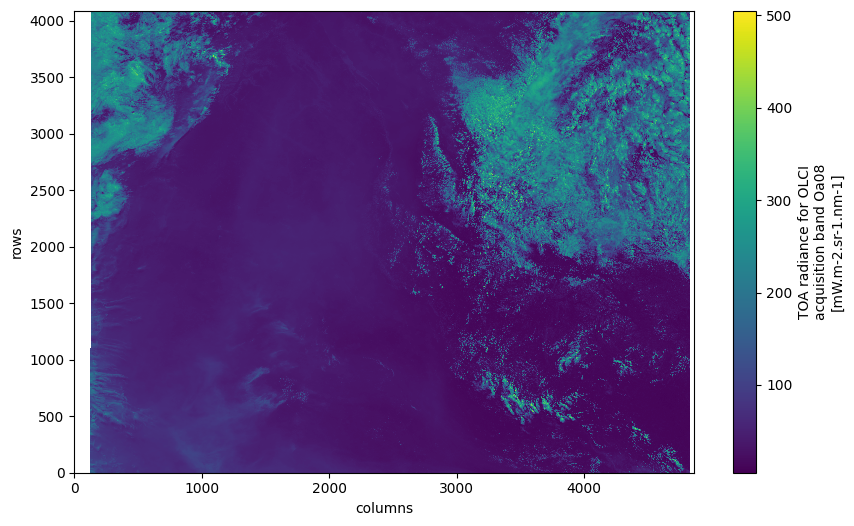

In [9]:
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa08_radiance'].plot.imshow()

## <a id='load_geo_coords'></a>Load OLCI geographic coordinates as `xarray`

If you want to georeference your image, you have to load the geographic coordinates file. You can load it as xarray with the function `xr.open_dataset()`. The file is called `geo_coordinates.nc`. You see that the file contains three variables: `latitude`, `longitude` and `altitude`. Latitude and longitude are the geographical coordinates. Altitude is the DEM corrected altitude of the 'Top-of-the-atmosphere' reflectance.

Let us store the latitude and longitude data as `lat` and `lon` variables respectively.

In [7]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')
olci_geo_coords

<xarray.Dataset>
Dimensions:    (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes: (12/16)
    absolute_orbit_number:  17173
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2021-08-13T06:38:50Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-12T03:13:07.277233Z
    stop_time:              2021-08-12T03:16:07.244935Z
    title:                  OLCI Level 1b Product, Geo Coordinates Data Set

In [8]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

lat, lon

(array([[62.923653, 62.923492, 62.923331, ..., 59.970293, 59.969282,
         59.96827 ],
        [62.921098, 62.920937, 62.920777, ..., 59.967885, 59.966873,
         59.965862],
        [62.918544, 62.918383, 62.918222, ..., 59.965476, 59.964465,
         59.963454],
        ...,
        [52.469605, 52.469379, 52.469153, ..., 49.90298 , 49.902169,
         49.901358],
        [52.467044, 52.466818, 52.466592, ..., 49.900477, 49.899666,
         49.898855],
        [52.464484, 52.464258, 52.464032, ..., 49.897973, 49.897162,
         49.896351]]),
 array([[ 99.348967,  99.354269,  99.35957 , ..., 123.336316, 123.340713,
         123.345111],
        [ 99.348608,  99.353909,  99.359211, ..., 123.334096, 123.338493,
         123.34289 ],
        [ 99.348249,  99.35355 ,  99.358851, ..., 123.331875, 123.336272,
         123.340669],
        ...,
        [ 97.829088,  97.833044,  97.836999, ..., 116.212148, 116.215692,
         116.219236],
        [ 97.828704,  97.832659,  97.836614, ...

## <a id='channel_select'></a>Select OLCI channels for a True-Color RGB image

True-Color images combine reflectances from the `red` (B04), `green` (B06) and `blue` (B04) light and resulting images look like real-world images, representing the Earth as humans see it naturally.


 The channel combination for a True-Color RGB (Red, Green, Blue) image of Sentinel-3 OLCI Level-1B data could be:
- Red: `Oa08_radiance`
- Green: `Oa06_radiance`
- Blue: `Oa04_radiance`

Alternatively, you can also try the combination `red` (B09), `green` (B06) and `blue` (B04).

You can use the function [select_channels_for_rgb](../functions.ipynb#rgb_channels), which helps you to combine different channels. The function returns the three bands individually.

In [9]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
red

<xarray.DataArray 'Oa08_radiance' (rows: 4091, columns: 4865)>
dask.array<open_dataset-4147b4867d777bc01eee60caaa07e7aaOa08_radiance, shape=(4091, 4865), dtype=float32, chunksize=(4091, 4865), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa08_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa08
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

## <a id='image_processing'></a>Advanced image processing - Normalization and histogram equalization

#### Normalization

A common operation in image processing is the normalization of data values. Normalization changes the range of pixel intensity and can improve the contrast. You can use the function [normalize](../functions.ipynb#normalize) to each RGB channel, **red**, **green** and **blue**. At the end, you can bring the three channels together into one `rgb` array with `numpy.dstack`. By verifying the shape of the resulting array, you see that the resulting `rgb` array has three dimensions, `rows`, `columns` and `number of channels`.

In [10]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [11]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4091, 4865, 3)

You can now plot the **rgb** image to see if maybe further image processing methods could be applied. If you visualize the image with `plt.imshow()`, you see that the constrast is not very strong. A further step is to sharpen the contrast with the help of a **Histogram equalization**.

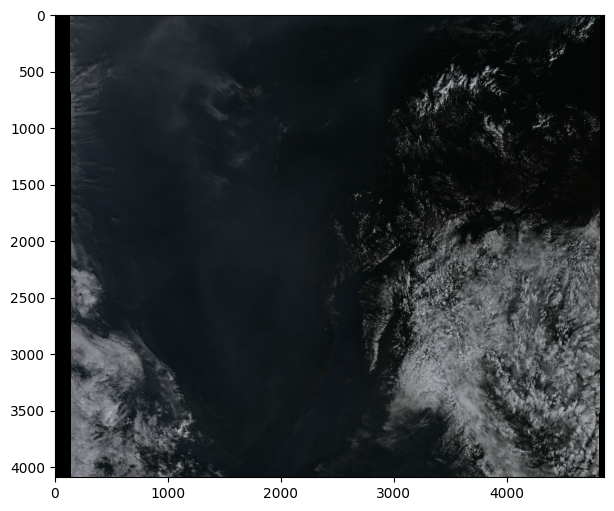

In [15]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

#### Histogram equalization

Histogram equalization is a method in image processing that adjusts the contrast using the image's histogram. Python's `skikit-learn` library has useful tools to make a histogram equalization. The `skimage` library provides a function `exposure.equalize_adaphtist()` which can be applied to the **rgb** data array.

In [12]:
rgb = exposure.equalize_adapthist(rgb)

You can again plot the rgb image with `plt.imshow()`. You can see that the histogram equalization improved the contrast of the image.

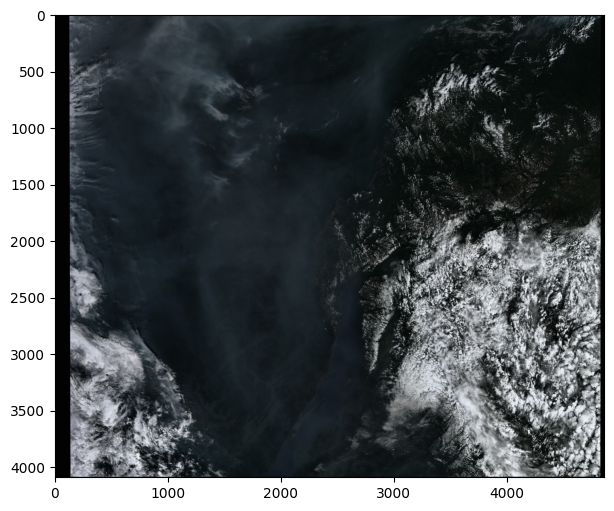

In [17]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

## <a id='visualize_tc'></a>Visualize a georeferenced RGB True-Color image with `pcolormesh`

The final step is to georeference the `RGB` image. Therefore, you need the extracted `lat` and `lon` information extracted above.

Let us plot the image with matplotlib's `pcolormesh` function. To be able to visualize the array as RGB True Color image, you have to map first the rgb array to a colour array.

In [13]:
mesh_rgb = rgb[:,:-1,:]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)

The last step is to visualize the color array and add additional information, e.g. gridlines and coastlines. You can use the function [visualize_s3_pcolormesh](../functions.ipynb#visualize_s3_pcolormesh) to do this.

As color_array, we use the `colorTuple` array and as array we use the shape of e.g. the `red` channel information.

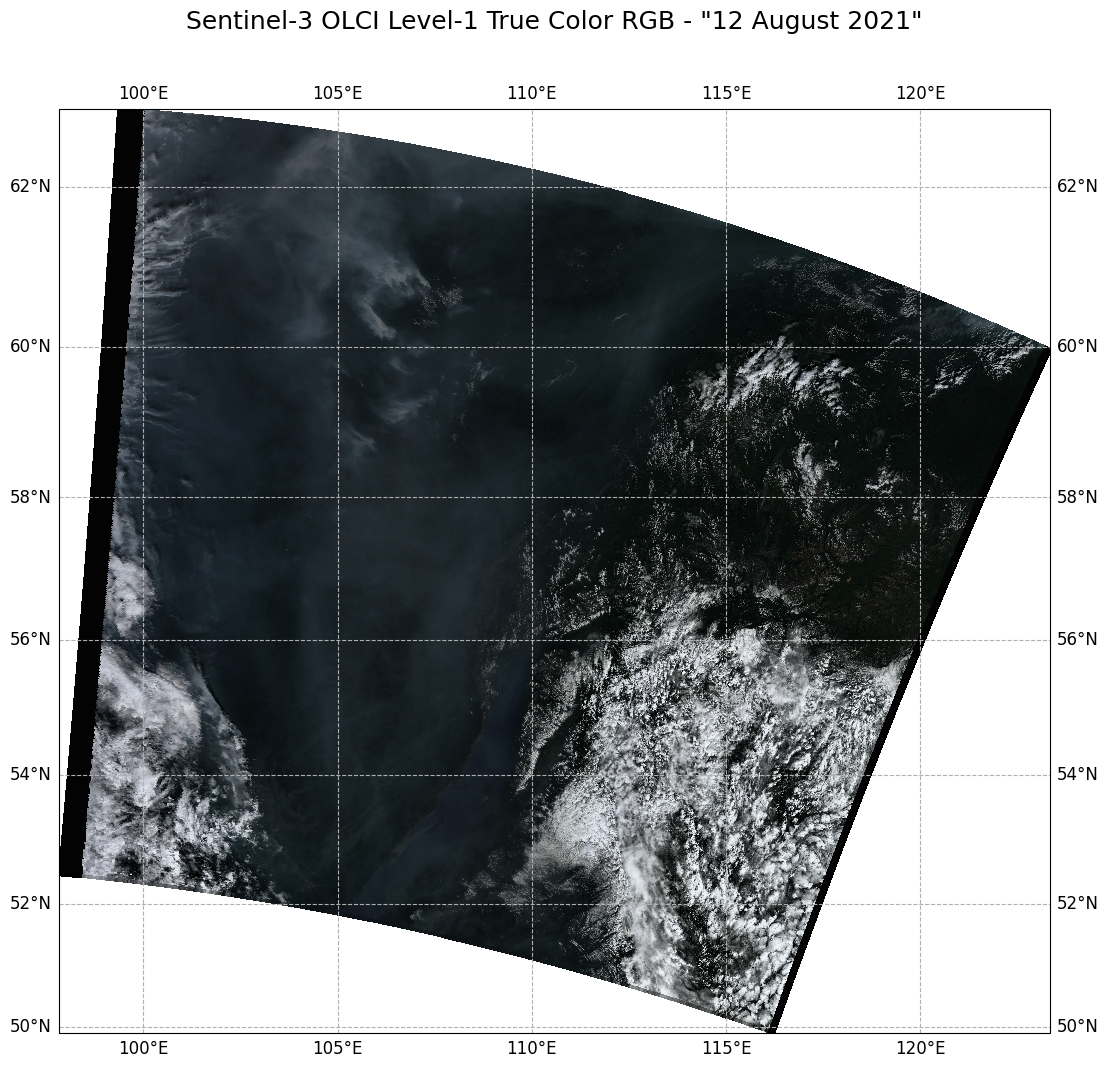

In [14]:
visualize_s3_pcolormesh(color_array = colorTuple,
                        array = red, 
                        latitude = lat, 
                        longitude = lon, 
                        title = 'Sentinel-3 OLCI Level-1 True Color RGB - "12 August 2021"')

<br>

## <a id='false_color'></a>Create a False Color RGB image and plot it as georeferenced image 

Instead of a true-color RGB image, a false-color RGB image can be created if specific phenomena should be highlighted. A channel combination to highlight smoke and fires from Sentinel-3 OLCI Level-1B data could be:
- Red: `Oa17_radiance`
- Green: `Oa05_radiance`
- Blue: `Oa02_radiance`

This selection identifies easier burnt areas and wildfires. The combination highlights healthy vegetation as red and burnt areas as black.

Let us repeat the steps from above to visualize the image as False Color RGB composite.

#### Select RGB channels

The first step is to select the channels `Oa17_radiance`, `Oa05_radiance` and `Oa02_radiance` as red, green and blue channels respectively.

In [21]:
red_fc, green_fc, blue_fc = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')

#### Normalize

You also want to normalize these channels and stack them afterwards into a three-dimensional array.

In [22]:
redn_fc = normalize(red_fc)
greenn_fc = normalize(green_fc)
bluen_fc = normalize(blue_fc)

In [23]:
rgb_fc = np.dstack((redn_fc, greenn_fc, bluen_fc))

#### Histogram equalization

Apply histogram equalization.

In [24]:
rgb_fc = exposure.equalize_adapthist(rgb_fc)

Let's have a sneak-peak to the un-georefrenced image with `plt.imshow()`

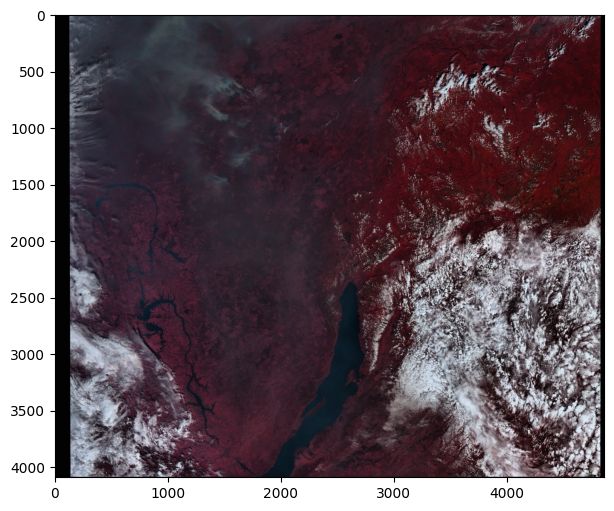

In [25]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb_fc)

#### Visualize with function `visualize_s3_pcolormesh`

First, map the stacked rgb array to a colour array and call it **colorTuple**.

In [29]:
mesh_rgb = rgb_fc[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

As a final step, visualize the geo-referenced false-colour RGB composite with the function [visualize_s3_pcolormesh](../functions.ipynb#visualize_s3_pcolormesh).

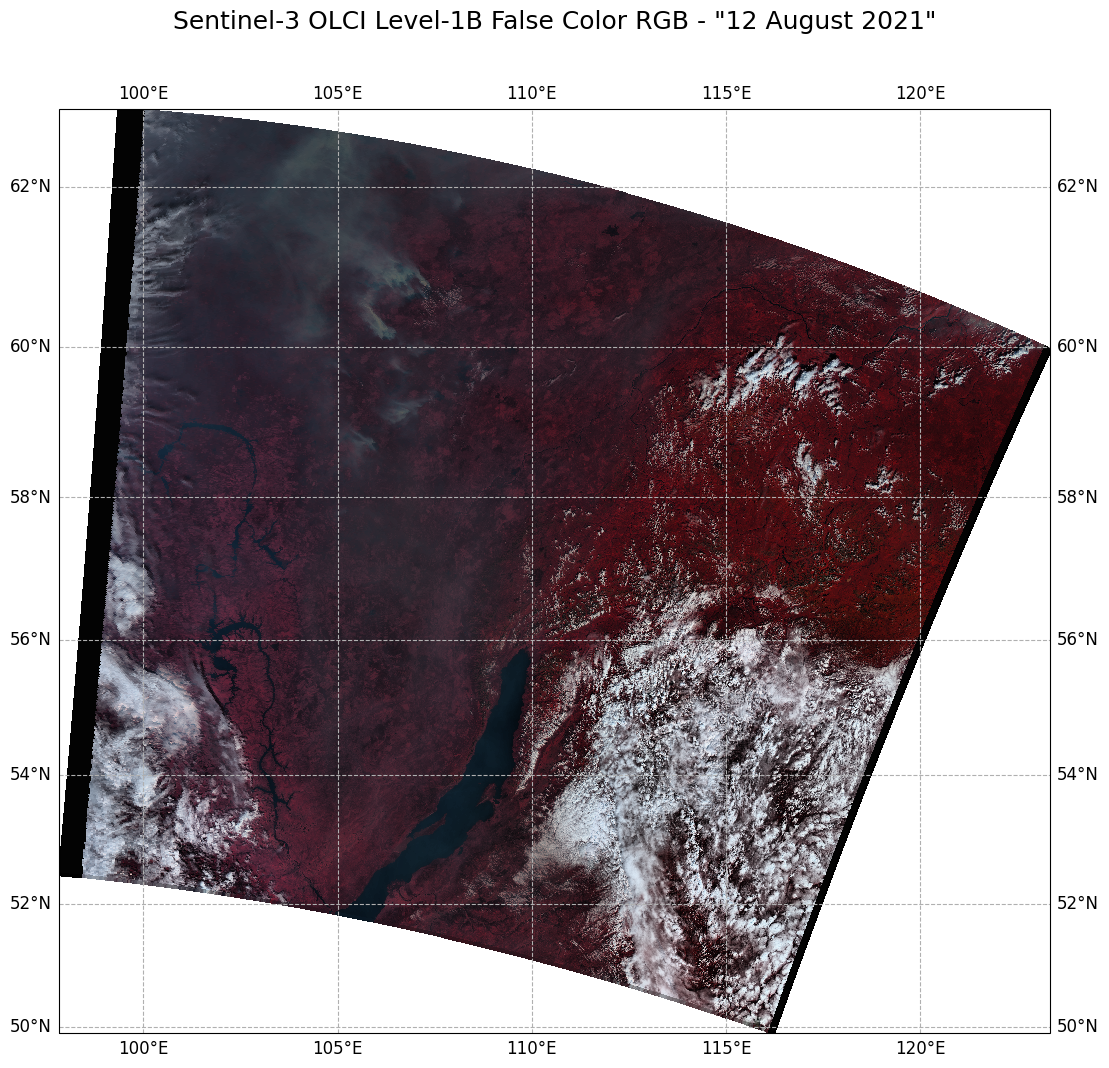

In [30]:
visualize_s3_pcolormesh(color_array = colorTuple, 
                        array = red_fc, 
                        latitude = lat, 
                        longitude = lon, 
                        title = 'Sentinel-3 OLCI Level-1B False Color RGB - "12 August 2021"')

<br>